Looking for patterns across all variables.

In [1]:
import logging

import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))
sys.path.append(root_dir)

import numpy as np
import pandas as pd

from importlib import reload

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# Load data

In [2]:
from sleep_events import load_days_data

day_data = load_days_data(False)

In [3]:
df = day_data.copy()

# Clustering, ANOVA, correlations
TODO: use the stuff from StatsExplorationTwoVariables to find patterns across all features.  Probably better done in UI.

# Data prep

In [4]:
import notebooks.DayData.day_data_processing as day_data_processing
reload(day_data_processing)

df_subset = day_data_processing.prep_day_data_subset(df)


Dropped 155 object columns: ['date:asStr', 'night:aggregated:sources:hypnogram', 'night:triedEEG', 'night:hasYasa', 'night:morningQuestionnaire:disturbances:Cat:readying']


# Subgroup discovery

In [5]:
df_subset.columns

Index(['weather:cloudCoverAfternoon', 'weather:humidityAfternoon',
       'weather:precipitationTotal', 'weather:temperatureMin',
       'weather:temperatureMax', 'weather:temperatureAfternoon',
       'weather:temperatureNight', 'weather:temperatureEvening',
       'weather:temperatureMorning', 'weather:pressureAfternoon',
       'weather:windMaxSpeed'],
      dtype='object')

In [6]:
import pysubgroup as ps
import numpy as np

target_col = 'weather_temperatureMax'
numeric_cols = [col for col in df_subset.select_dtypes(include=[np.number]).columns
                if not pd.api.types.is_timedelta64_dtype(df_subset[col])]
df_test = df_subset[numeric_cols]

df_test.columns = [c.replace(':', '_') for c in df_test.columns]
target = ps.NumericTarget(target_col)
searchspace = ps.create_selectors(df_test, ignore=[target_col])
qf = ps.StandardQFNumeric(1.0)
task = ps.SubgroupDiscoveryTask(df_test, target, searchspace, qf=qf)
result = ps.BeamSearch().execute(task)
result_df = result.to_dataframe()
result_df


,quality,subgroup,size_sg,size_dataset,mean_sg,mean_dataset,std_sg,std_dataset,median_sg,median_dataset,max_sg,max_dataset,min_sg,min_dataset,mean_lift,median_lift
0,559.741421,weather_temperatureEvening>=17.71,72,359,21.537083,13.762897,2.374673,5.708919,20.865,14.13,27.83,27.83,17.92,1.15,1.564866,1.476645
1,549.841421,weather_temperatureAfternoon>=17.18,72,359,21.399583,13.762897,2.515767,5.708919,20.865,14.13,27.83,27.83,17.78,1.15,1.554875,1.476645
2,503.910390,weather_temperatureAfternoon>=17.18 AND weathe...,62,359,21.890484,13.762897,2.359499,5.708919,21.450,14.13,27.83,27.83,18.24,1.15,1.590543,1.518047
3,496.441421,weather_temperatureNight>=13.34,72,359,20.657917,13.762897,3.210360,5.708919,19.975,14.13,27.83,27.83,13.62,1.15,1.500986,1.413659
4,457.441421,weather_temperatureMin>=11.83,72,359,20.116250,13.762897,3.280115,5.708919,19.610,14.13,27.83,27.83,13.62,1.15,1.461629,1.387827
5,439.801421,weather_temperatureMorning>=12.30,72,359,19.871250,13.762897,3.493351,5.708919,19.495,14.13,27.83,27.83,13.39,1.15,1.443828,1.379689
6,438.343565,weather_temperatureAfternoon>=17.18 AND weathe...,54,359,21.880370,13.762897,2.603469,5.708919,21.725,14.13,27.83,27.83,17.78,1.15,1.589808,1.537509
7,426.602256,weather_temperatureEvening>=17.71 AND weather_...,51,359,22.127647,13.762897,2.473533,5.708919,21.840,14.13,27.83,27.83,18.58,1.15,1.607775,1.545648
8,425.063287,weather_temperatureMin>=11.83 AND weather_temp...,61,359,20.731148,13.762897,3.107706,5.708919,19.910,14.13,27.83,27.83,14.66,1.15,1.506307,1.409059
9,417.000390,weather_temperatureMin>=11.83 AND weather_temp...,62,359,20.488710,13.762897,3.262838,5.708919,19.905,14.13,27.83,27.83,13.62,1.15,1.488692,1.408705


# QARMA

In [7]:

import notebooks.Stats.stats_qarma as stats_qarma
reload(stats_qarma)

# Create an example dataset with some missing values
np.random.seed(42)

# Create sample data with age, income, and purchase behavior
n_samples = 200

data = {
    'Age': np.random.normal(40, 15, n_samples),
    'Income': np.random.normal(50000, 20000, n_samples),
    'ShoppingFrequency': np.random.normal(5, 2, n_samples)
}

# Add some categorical features
data['LikesOnlineShopping'] = np.random.choice([0, 1], size=n_samples, p=[0.3, 0.7])
data['PrefersPremiumBrands'] = np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4])
data['HasLoyaltyCard'] = np.random.choice([0, 1], size=n_samples, p=[0.5, 0.5])

# Create some relationships in the data
# People with higher income tend to prefer premium brands
data['PrefersPremiumBrands'] = np.where(
    data['Income'] > 60000,
    np.random.choice([0, 1], size=n_samples, p=[0.3, 0.7]),
    np.random.choice([0, 1], size=n_samples, p=[0.8, 0.2])
)

# Older people shop less frequently
data['ShoppingFrequency'] = np.where(
    data['Age'] > 55,
    data['ShoppingFrequency'] * 0.7,
    data['ShoppingFrequency']
)

# Create a DataFrame
test_df = pd.DataFrame(data)

# Introduce some missing values
test_df.loc[np.random.choice(n_samples, size=15), 'Age'] = np.nan
test_df.loc[np.random.choice(n_samples, size=20), 'Income'] = np.nan
test_df.loc[np.random.choice(n_samples, size=10), 'PrefersPremiumBrands'] = np.nan

print("Sample data:")
print(test_df.head())
print("\nData shape:", test_df.shape)
print("\nMissing values count:")
print(test_df.isna().sum())

# Apply QARMA
qarma = stats_qarma.QARMA(min_support=0.1, min_confidence=0.6)
qarma.fit(test_df, discretize=True, num_bins=3)

print("\nQARMA Results:")
qarma.print_rules(n=5)    

Sample data:
         Age        Income  ShoppingFrequency  LikesOnlineShopping  \
0  47.450712  57155.747207           1.811145                    0   
1  37.926035  61215.690527           3.801250                    1   
2  49.715328  71661.024864           5.010487                    1   
3  62.845448  71076.041041           3.565773                    1   
4  36.487699  22446.612641           4.099869                    1   

   PrefersPremiumBrands  HasLoyaltyCard  
0                   0.0               1  
1                   1.0               0  
2                   1.0               1  
3                   1.0               1  
4                   0.0               1  

Data shape: (200, 6)

Missing values count:
Age                     15
Income                  18
ShoppingFrequency        0
LikesOnlineShopping      0
PrefersPremiumBrands     9
HasLoyaltyCard           0
dtype: int64
Starting QARMA with 200 rows and 6 columns
Handling missing values...


Processing missing values:   0%|          | 0/6 [00:00<?, ?it/s]

Created 3 missing indicator column(s): ['Age_missing', 'Income_missing', 'PrefersPremiumBrands_missing']
Discretizing data...


Discretizing columns:   0%|          | 0/9 [00:00<?, ?it/s]

Dropped 0 constant column(s): []
Converting to transaction format...


Creating transactions:   0%|          | 0/200 [00:00<?, ?it/s]

Generating frequent itemsets...
Counting individual items...


Counting 1-itemsets:   0%|          | 0/200 [00:00<?, ?it/s]

Finding 2-itemsets...


Generating 2-itemset candidates:   0%|          | 0/120 [00:00<?, ?it/s]

Counting support for 120 candidate 2-itemsets...


Computing support for 2-itemsets:   0%|          | 0/120 [00:00<?, ?it/s]

Found 89 frequent 2-itemsets
Finding 3-itemsets...


Generating 3-itemset candidates:   0%|          | 0/3916 [00:00<?, ?it/s]

Counting support for 434 candidate 3-itemsets...


Computing support for 3-itemsets:   0%|          | 0/434 [00:00<?, ?it/s]

Found 244 frequent 3-itemsets
Generating association rules...
Generating rules from 2-itemsets...


Processing 2-itemsets:   0%|          | 0/89 [00:00<?, ?it/s]

Generating rules from 3-itemsets...


Processing 3-itemsets:   0%|          | 0/244 [00:00<?, ?it/s]

Generated 648 rules

Timing Summary:
--------------------------------------------------
Handle Missing Values: 0.02 seconds (14.2%)
Discretize Data: 0.02 seconds (13.0%)
Get Transactions: 0.04 seconds (29.2%)
Generate Itemsets: 0.05 seconds (32.2%)
Generate Rules: 0.02 seconds (11.4%)
--------------------------------------------------
Total execution time: 0.15 seconds

QARMA Results:
Found 5 rules with support >= 0.1 and confidence >= 0.6
--------------------------------------------------------------------------------
Rule 1: ShoppingFrequency_low, PrefersPremiumBrands_low => HasLoyaltyCard_high
  Support: 0.115
  Confidence: 0.676
  Lift: 1.367
--------------------------------------------------------------------------------
Rule 2: Income_low => LikesOnlineShopping_high, Income_missing_low
  Support: 0.100
  Confidence: 0.741
  Lift: 1.245
--------------------------------------------------------------------------------
Rule 3: ShoppingFrequency_medium, LikesOnlineShopping_low => HasL

In [8]:
# Dies...

import notebooks.Stats.stats_qarma as stats_qarma
reload(stats_qarma)

qarma = stats_qarma.QARMA(min_support=0.1, min_confidence=0.6)
out = qarma.fit(df_subset, discretize=True, num_bins=3)


Starting QARMA with 359 rows and 11 columns
Handling missing values...


Processing missing values:   0%|          | 0/11 [00:00<?, ?it/s]

Created 0 missing indicator column(s): []
Discretizing data...


Discretizing columns:   0%|          | 0/11 [00:00<?, ?it/s]

Dropped 0 constant column(s): []
Converting to transaction format...


Creating transactions:   0%|          | 0/359 [00:00<?, ?it/s]

Generating frequent itemsets...
Counting individual items...


Counting 1-itemsets:   0%|          | 0/359 [00:00<?, ?it/s]

Finding 2-itemsets...


Generating 2-itemset candidates:   0%|          | 0/406 [00:00<?, ?it/s]

Counting support for 406 candidate 2-itemsets...


Computing support for 2-itemsets:   0%|          | 0/406 [00:00<?, ?it/s]

Found 220 frequent 2-itemsets
Finding 3-itemsets...


Generating 3-itemset candidates:   0%|          | 0/24090 [00:00<?, ?it/s]

Counting support for 1855 candidate 3-itemsets...


Computing support for 3-itemsets:   0%|          | 0/1855 [00:00<?, ?it/s]

Found 589 frequent 3-itemsets
Generating association rules...
Generating rules from 2-itemsets...


Processing 2-itemsets:   0%|          | 0/220 [00:00<?, ?it/s]

Generating rules from 3-itemsets...


Processing 3-itemsets:   0%|          | 0/589 [00:00<?, ?it/s]

Generated 1444 rules

Timing Summary:
--------------------------------------------------
Handle Missing Values: 0.01 seconds (4.2%)
Discretize Data: 0.02 seconds (14.1%)
Get Transactions: 0.04 seconds (24.3%)
Generate Itemsets: 0.08 seconds (49.5%)
Generate Rules: 0.01 seconds (7.8%)
--------------------------------------------------
Total execution time: 0.17 seconds


# Causal discovery

In [9]:
!pip install lingam

In [10]:
%matplotlib inline


In [11]:
import stats_causal
reload(stats_causal)

processed_data, removed_cols = stats_causal.preprocess_for_causal_discovery(df_full)


PC.py
cdt (CausalDiscoveryToolbox) not available. Some algorithms will be skipped.
cdt (CausalDiscoveryToolbox) not available. Some algorithms will be skipped.


NameError: name 'df_full' is not defined

In [129]:
import causallearn.search.ConstraintBased as CB

# List all attributes inside the ConstraintBased module
print(dir(CB))


['CDNOD', 'FCI', 'PC', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__']


In [131]:
from causallearn.search.ConstraintBased import PC
import inspect

print("PC type:", type(PC))
print("PC is defined in:", inspect.getfile(PC))


PC type: <class 'module'>
PC is defined in: c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\causallearn\search\ConstraintBased\PC.py


In [126]:
import causallearn.search.ConstraintBased.PC as PC  
# reload(PC)
reload(causallearn.search.ConstraintBased.PC)
# from causallearn.search.ConstraintBased.PC import pc

#from causallearn.search.ConstraintBased.PC import pc


ModuleNotFoundError: spec not found for the module 'causallearn.search.ConstraintBased.PC'

In [17]:
import inspect

print(inspect.getfile(PC))
 

PC.py
c:\dev\brainwave-processor\notebooks\stats\causal-learn\causallearn\search\ConstraintBased\PC.py


In [24]:
df_full = day_data_processing.prep_day_data(df)
df_full.reset_index(inplace=True)
df_full.drop(columns=['dayAndNightOf'], inplace=True)


Dropped 155 object columns: ['date:asStr', 'night:aggregated:sources:hypnogram', 'night:triedEEG', 'night:hasYasa', 'night:morningQuestionnaire:disturbances:Cat:readying']


In [ ]:
import stats_causal
reload(stats_causal)

import causallearn.graph.GraphClass as GraphClass
reload(GraphClass)

import causallearn.utils.cit as cit
reload(cit)

import causallearn.search.ConstraintBased.PC as PC
reload(PC)
import causallearn.utils.PCUtils.SkeletonDiscovery as SkeletonDiscovery
reload(SkeletonDiscovery)


import stats_causal_plot
reload(stats_causal_plot)
import matplotlib.pyplot as plt
# fake_news = stats_causal.generate_synthetic_circadian_data()


pc_results = stats_causal.run_pc_algorithm(df_subset, alpha=0.001, skip_preprocessing=True, verbose=True)
highlight_nodes=['asleepTime', 'LEP:datetime', 'wakeTime', 'readyToSleepTime']
out = stats_causal_plot.plot_causal_graph(pc_results)

cdt (CausalDiscoveryToolbox) not available. Some algorithms will be skipped.
PC.py
cdt (CausalDiscoveryToolbox) not available. Some algorithms will be skipped.
PC algorithm 3
Missing value PC algorithm 2542


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\dev\brainwave-processor\notebooks\stats\causal-learn\causallearn\search\ConstraintBased\PC.py:39: UserWarning: The number of features is much larger than the sample size!
  warnings.warn("The number of features is much larger than the sample size!")


  0%|          | 0/2410 [00:00<?, ?it/s]

c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


MV_FisherZ X night:nightEvents:wakingsWithDurationCount Y date:daysSince condition_set [] r nan Z nan X_stat nan p nan
MV_FisherZ X night:nightEvents:wakingsWithDurationCount Y date:dayOfWeek condition_set [] r 0.01 Z 0.01 X_stat 0.14 p 0.89
MV_FisherZ X night:nightEvents:wakingsWithDurationCount Y date:dayOfMonth condition_set [] r 0.12 Z 0.12 X_stat 2.23 p 0.03
MV_FisherZ X night:nightEvents:wakingsWithDurationCount Y date:month condition_set [] r -0.16 Z -0.17 X_stat 3.12 p 0.00
MV_FisherZ X night:nightEvents:wakingsWithDurationCount Y date:year condition_set [] r 0.01 Z 0.01 X_stat 0.25 p 0.80
MV_FisherZ X night:nightEvents:wakingsWithDurationCount Y weather:cloudCoverAfternoon condition_set [] r -0.05 Z -0.05 X_stat 0.99 p 0.32
MV_FisherZ X night:nightEvents:wakingsWithDurationCount Y weather:humidityAfternoon condition_set [] r -0.08 Z -0.08 X_stat 1.56 p 0.12
MV_FisherZ X night:nightEvents:wakingsWithDurationCount Y weather:precipitationTotal condition_set [] r -0.04 Z -0.04 X_s

c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\numpy\lib\_function_base_impl.py:2991: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


MV_FisherZ X night:nightEvents:wakingsWithDurationCount Y night:yasaExtended:Stability:Fpz-M1:N2 condition_set [] r nan Z nan X_stat nan p nan
MV_FisherZ X night:nightEvents:wakingsWithDurationCount Y night:yasaExtended:Stability:Fpz-M1:N3 condition_set [] r nan Z nan X_stat nan p nan
MV_FisherZ X night:nightEvents:wakingsWithDurationCount Y night:yasaExtended:Stability:Fpz-M1:REM condition_set [] r nan Z nan X_stat nan p nan
MV_FisherZ X night:nightEvents:wakingsWithDurationCount Y night:yasaExtended:Stability:Fpz-M1:Sleep condition_set [] r nan Z nan X_stat nan p nan
MV_FisherZ X night:nightEvents:wakingsWithDurationCount Y night:yasaExtended:Stability:F4-M1:AnyStage hit error math domain error
MV_FisherZ X night:nightEvents:wakingsWithDurationCount Y night:yasaExtended:Stability:F4-M1:Wake hit error math domain error
MV_FisherZ X night:nightEvents:wakingsWithDurationCount Y night:yasaExtended:Stability:F4-M1:N1 hit error math domain error
MV_FisherZ X night:nightEvents:wakingsWithDu

KeyboardInterrupt: 

cdt (CausalDiscoveryToolbox) not available. Some algorithms will be skipped.
Correlation matrix is now invertible
Unknown graph type. Graph attributes: ['__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'clear', 'copy', 'fromkeys', 'get', 'items', 'keys', 'pop', 'popitem', 'setdefault', 'update', 'values']
Final graph has 11 nodes and 0 edges


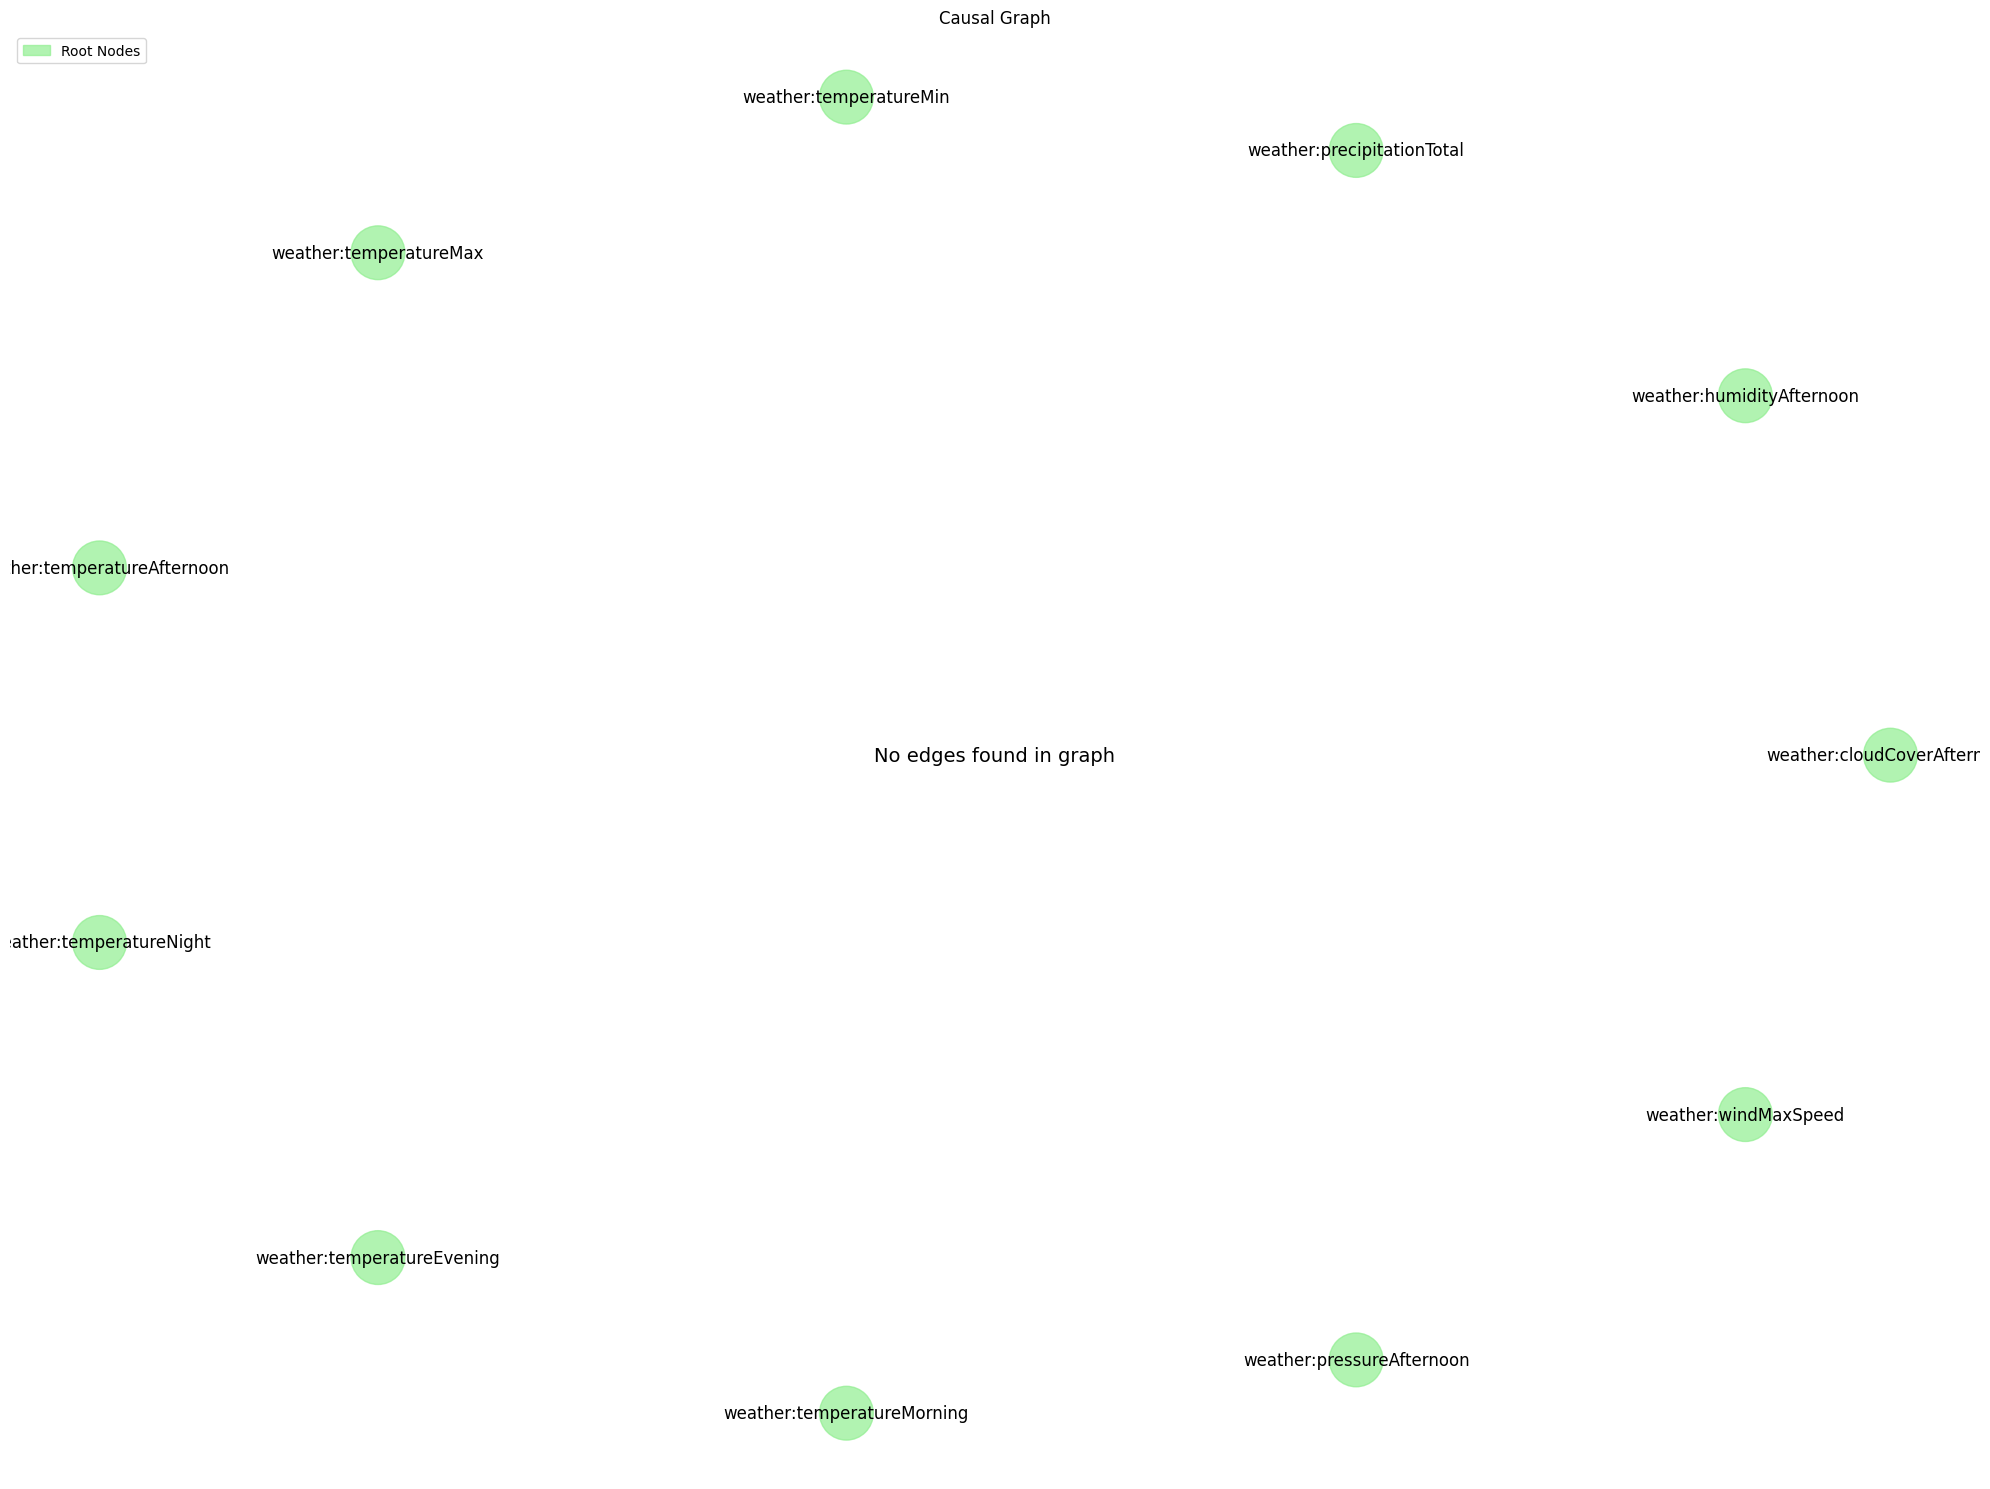

In [ ]:
import stats_causal
reload(stats_causal)

# fake_news = stats_causal.generate_synthetic_circadian_data()
pc_results = stats_causal.run_ges_algorithm(df_subset)
stats_causal.plot_causal_graph(pc_results)

## CD: FCI

In [40]:
import stats_causal
reload(stats_causal)

import notebooks.DayData.day_data_processing as day_data_processing
reload(day_data_processing)

df_full = day_data_processing.prep_day_data(df)
df_full.reset_index(inplace=True)
df_full.drop(columns=['dayAndNightOf'], inplace=True)
results = stats_causal.run_fci_algorithm(df_subset, 0.05)
stats_causal.plot_causal_graph(results, highlight_nodes=highlight_nodes)

cdt (CausalDiscoveryToolbox) not available. Some algorithms will be skipped.
Dropped 155 object columns: ['date:asStr', 'night:aggregated:sources:hypnogram', 'night:triedEEG', 'night:hasYasa', 'night:morningQuestionnaire:disturbances:Cat:readying']
Running FCI algorithm...


AssertionError: Input data must be a numpy array.

In [99]:
# TypeError: could not convert string to float: '2025-02-03'
[c for c in df_full.columns if str(df_full[c].dtype) == 'object']

['date:asStr',
 'night:aggregated:sources:hypnogram',
 'night:triedEEG',
 'night:hasYasa',
 'night:morningQuestionnaire:disturbances:Cat:readying',
 'night:morningQuestionnaire:disturbances:Cat:insomnia',
 'night:morningQuestionnaire:disturbances:Cat:disturbed',
 'night:morningQuestionnaire:disturbances:Tensed shoulders:insomnia',
 'night:morningQuestionnaire:disturbances:Tensed shoulders:disturbed',
 'night:morningQuestionnaire:disturbances:Tensed shoulders:readying',
 'night:morningQuestionnaire:disturbances:Too warm:insomnia',
 'night:morningQuestionnaire:disturbances:Too warm:disturbed',
 'night:morningQuestionnaire:disturbances:Too warm:readying',
 'night:morningQuestionnaire:disturbances:Thinking about work:disturbed',
 'night:morningQuestionnaire:disturbances:Thinking about work:insomnia',
 'night:morningQuestionnaire:disturbances:Thinking about work:readying',
 'night:morningQuestionnaire:disturbances:Whirling thoughts:insomnia',
 'night:morningQuestionnaire:disturbances:Whirli

In [96]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Columns: 2697 entries, date:daysSince to sunExposure:lastOutsideHSM
dtypes: float64(2456), int64(86), object(155)
memory usage: 7.4+ MB


In [94]:
df_full.select_dtypes(include=['string']).columns

Index([], dtype='object')

## CD-NOD
Probably quite helpful but need to manually tell it what 'mode' each day is in.

In [67]:
import stats_causal
reload(stats_causal)

results = stats_causal.run_cd_nod_algorithm(df_subset, 0)
stats_causal.plot_causal_graph(results)

cdt (CausalDiscoveryToolbox) not available. Some algorithms will be skipped.
CD-NOD algorithm not available. Skipping.
No graph to plot for Causal Graph


## CD: ICA lingam

In [68]:
import stats_causal
reload(stats_causal)

results = stats_causal.run_ica_lingam_algorithm(df_subset)
stats_causal.plot_causal_graph(results)


cdt (CausalDiscoveryToolbox) not available. Some algorithms will be skipped.
Correlation matrix is now invertible
Running ICA-LiNGAM algorithm...
Created graph with 11 nodes and 32 edges
Using existing NetworkX graph with 11 nodes and 32 edges
Final graph has 11 nodes and 32 edges


In [69]:
import stats_causal
reload(stats_causal)

results = stats_causal.run_rcd_algorithm(df_subset)
stats_causal.plot_causal_graph(results, highlight_nodes=highlight_nodes)


cdt (CausalDiscoveryToolbox) not available. Some algorithms will be skipped.
RCD algorithm not available. Skipping.
No graph to plot for Causal Graph


In [ ]:
import stats_causal
reload(stats_causal)

results = stats_causal.run_cam_uv_algorithm(df_subset)
stats_causal.plot_causal_graph(results, highlight_nodes=highlight_nodes)


Removed highly correlated feature: totalTimeAnySun (corr: 1.0000)
Removed highly correlated feature: luminette:last (corr: 0.9993)
Correlation matrix is now invertible
Removed 2 problematic columns for CAM-UV algorithm
Running CAM-UV algorithm...
Error running CAM-UV algorithm: R Package CAM is not available.
No graph to plot for Causal Graph


In [ ]:
import stats_causal
reload(stats_causal)

results = stats_causal.run_grasp_algorithm(df_subset, score_func="local_score_marginal_multi")
stats_causal.plot_causal_graph(results, highlight_nodes=highlight_nodes)


Removed highly correlated feature: totalTimeAnySun (corr: 1.0000)
Removed highly correlated feature: luminette:last (corr: 0.9993)
Correlation matrix is now invertible
Removed 2 problematic columns for GRaSP algorithm
Running GRaSP algorithm...
Error running GRaSP algorithm: 0
No graph to plot for Causal Graph


In [ ]:
import stats_causal
reload(stats_causal)

results = stats_causal.run_pnl_algorithm(df_subset)
stats_causal.plot_causal_graph(results)


ImportError: Unable to import required dependencies:
pytz: No module named 'pytz'

In [ ]:
import stats_causal
reload(stats_causal)

results = stats_causal.run_boss_algorithm(df_subset, score_func = "local_score_marginal_general")
stats_causal.plot_causal_graph(results)


Removed highly correlated feature: totalTimeAnySun (corr: 1.0000)
Removed highly correlated feature: luminette:last (corr: 0.9993)
Correlation matrix is now invertible
Removed 2 problematic columns for BOSS algorithm
Running BOSS algorithm...
Error running BOSS algorithm: (slice(None, None, None), 0)
No graph to plot for Causal Graph


In [50]:
out.print_rules(n=5)

Found 5 rules with support >= 0.1 and confidence >= 0.6
--------------------------------------------------------------------------------
Rule 1: weather:temperatureMorning_low => weather:temperatureMin_low, weather:temperatureNight_low
  Support: 0.111
  Confidence: 0.889
  Lift: 7.091
--------------------------------------------------------------------------------
Rule 2: weather:temperatureMin_low, weather:temperatureNight_low => weather:temperatureMorning_low
  Support: 0.111
  Confidence: 0.889
  Lift: 7.091
--------------------------------------------------------------------------------
Rule 3: weather:temperatureMorning_low => weather:temperatureMin_low, weather:precipitationTotal_low
  Support: 0.117
  Confidence: 0.933
  Lift: 6.444
--------------------------------------------------------------------------------
Rule 4: weather:temperatureMin_low, weather:precipitationTotal_low => weather:temperatureMorning_low
  Support: 0.117
  Confidence: 0.808
  Lift: 6.444
----------------